# HW-3
### Q1 GDA

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

data = np.loadtxt("spambase/spambase.data", delimiter=',')
X = data[:, :-1]
y = data[:, -1]

scaler_spam = StandardScaler()
X_norm = scaler_spam.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.2, random_state=42
)

X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]

X_test_bias = np.c_[np.ones((X_test.shape[0], 1)), X_test]

In [4]:
class GDA:
    def __init__(self, cov_type="single"):
        self.cov_type = cov_type
        self.priors = {}
        self.means = {}
        self.covariances = {}
        self.shared_cov = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples = X.shape[0]

        for c in self.classes:
            X_c = X[y==c]

            self.priors[c] = len(X_c) / n_samples
            self.means[c] = np.mean(X_c, axis=0)

            if self.cov_type == 'class_conditional':
                self.covariances[c] = np.cov(X_c.T, bias=True)

        if self.cov_type == 'single':
            self.shared_cov = self._compute_pooled_covariance(X, y)

    def _compute_pooled_covariance(self, X, y):
        n_samples = X.shape[0]
        n_features = X.shape[1]
        n_classes = len(self.classes)

        pooled_cov = np.zeros((n_features, n_features))

        for c in self.classes:
            X_c = X[y==c]
            mean_c = self.means[c]

            X_centered = X_c - mean_c

            pooled_cov += X_centered.T @ X_centered

        pooled_cov /= (n_samples - n_classes)

        return pooled_cov

    def predict(self, X):
        """
        Predict class labels using LDA and QDA
        """
        predictions = []

        for x in X:
            discriminants = {}

            for c in self.classes:
                if self.cov_type == 'single':
                    discriminants[c] = self.lda_discriminant(x,c)
                else:
                    discriminants[c] = self.qda_discriminant(x,c)

            predictions.append(max(discriminants, key=discriminants.get))

        return np.array(predictions)

    def lda_discriminant(self, x, c):
        """
        LDA discriminant: δ_c(x) = x^T Σ^{-1} μ_c - 0.5 μ_c^T Σ^{-1} μ_c + log(π_c)
        """
        mean_c = self.means[c]
        prior_c = self.priors[c]

        cov_inv = np.linalg.inv(
            self.shared_cov + 1e-6 * np.eye(len(self.shared_cov))
        )

        discriminant = x @ cov_inv @ mean_c
        discriminant -= 0.5 * mean_c @ cov_inv @ mean_c
        discriminant += np.log(prior_c)

        return discriminant

    def qda_discriminant(self, x, c):
        """
        QDA discriminant: δ_c(x) = -0.5 log|Σ_c| - 0.5 (x-μ_c)^T Σ_c^{-1} (x-μ_c) + log(π_c)
        """
        mean_c = self.means[c]
        cov_c = self.covariances[c]
        prior_c = self.priors[c]

        cov_c_reg = cov_c + 1e-6 * np.eye(len(cov_c))

        diff = x-mean_c
        cov_inv = np.linalg.inv(cov_c_reg)

        discriminant = -0.5*np.log(np.linalg.det(cov_c_reg))
        discriminant -= 0.5*diff @ cov_inv @ diff
        discriminant += np.log(prior_c)

        return discriminant

In [5]:
def KFOLD_CV_GDA(X, y, k_folds=10):
    results = {
        'LDA': {'train_acc': [], 'test_acc': []},
        'QDA': {'train_acc': [], 'test_acc': []}
    }

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        for name, cov_type in [('LDA', 'single'), ('QDA', 'class_conditional')]:
            gda = GDA(cov_type=cov_type)
            gda.fit(X_train, y_train)

            train_pred = gda.predict(X_train)
            test_pred = gda.predict(X_test)

            train_acc = accuracy_score(y_train, train_pred)
            test_acc = accuracy_score(y_test, test_pred)

            results[name]['train_acc'].append(train_acc)
            results[name]['test_acc'].append(test_acc)

        print(f"Fold {fold+1} complete")

    for model in ['LDA', 'QDA']:
        print(f"\n{model} Results:")
        print(f"  Train Acc: {np.mean(results[model]['train_acc']):.4f} ± {np.std(results[model]['train_acc']):.4f}")
        print(f"  Test Acc:  {np.mean(results[model]['test_acc']):.4f} ± {np.std(results[model]['test_acc']):.4f}")

    return results

results = KFOLD_CV_GDA(X_norm, y)

/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fold 1 complete


/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fold 2 complete


/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fold 3 complete


/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fold 4 complete


/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fold 5 complete


/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fold 6 complete


/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fold 7 complete


/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fold 8 complete


/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fold 9 complete


/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/yashlad/Development/CS6140/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fold 10 complete

LDA Results:
  Train Acc: 0.8899 ± 0.0017
  Test Acc:  0.8872 ± 0.0099

QDA Results:
  Train Acc: 0.8326 ± 0.0041
  Test Acc:  0.8298 ± 0.0172


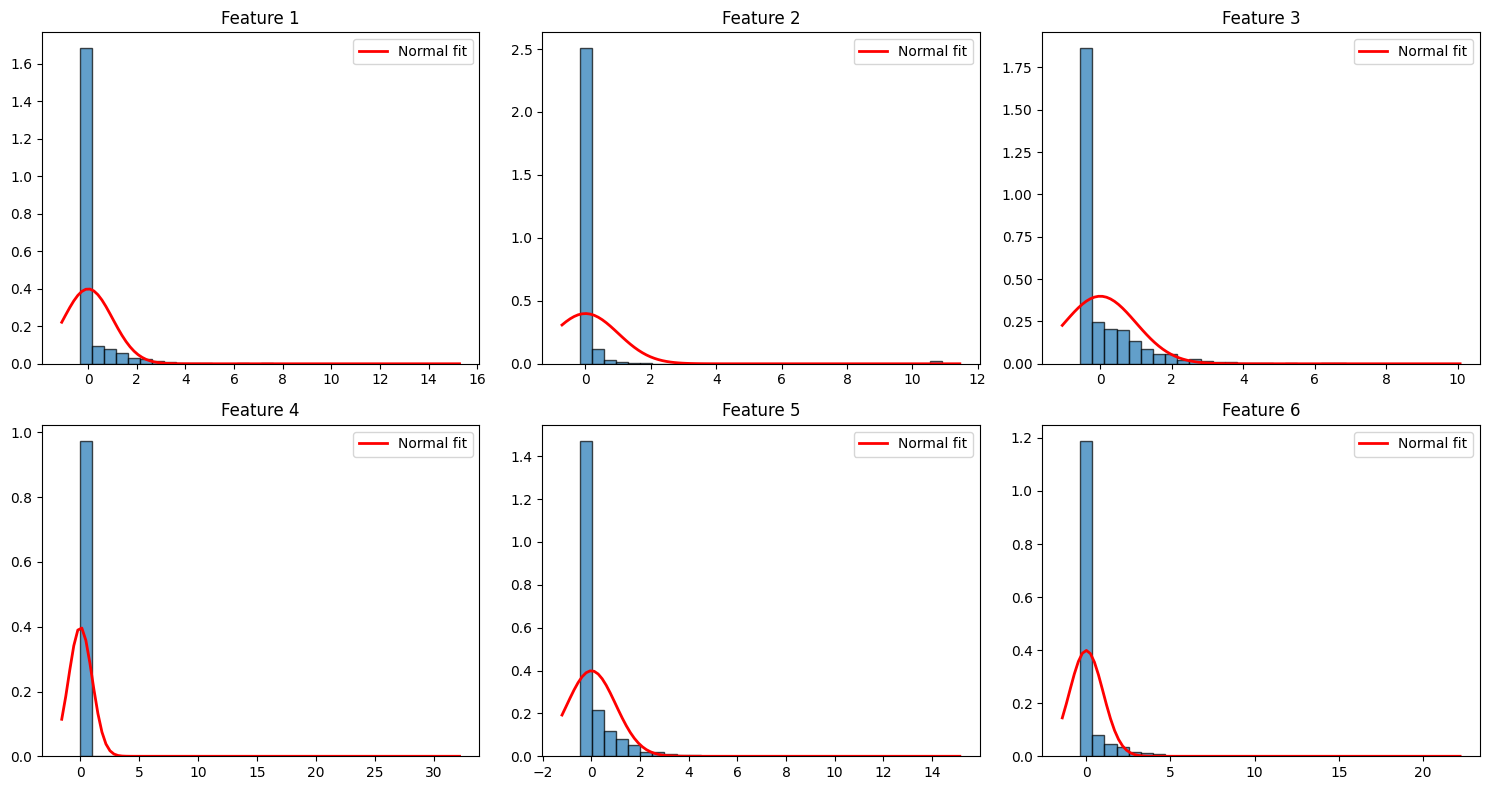

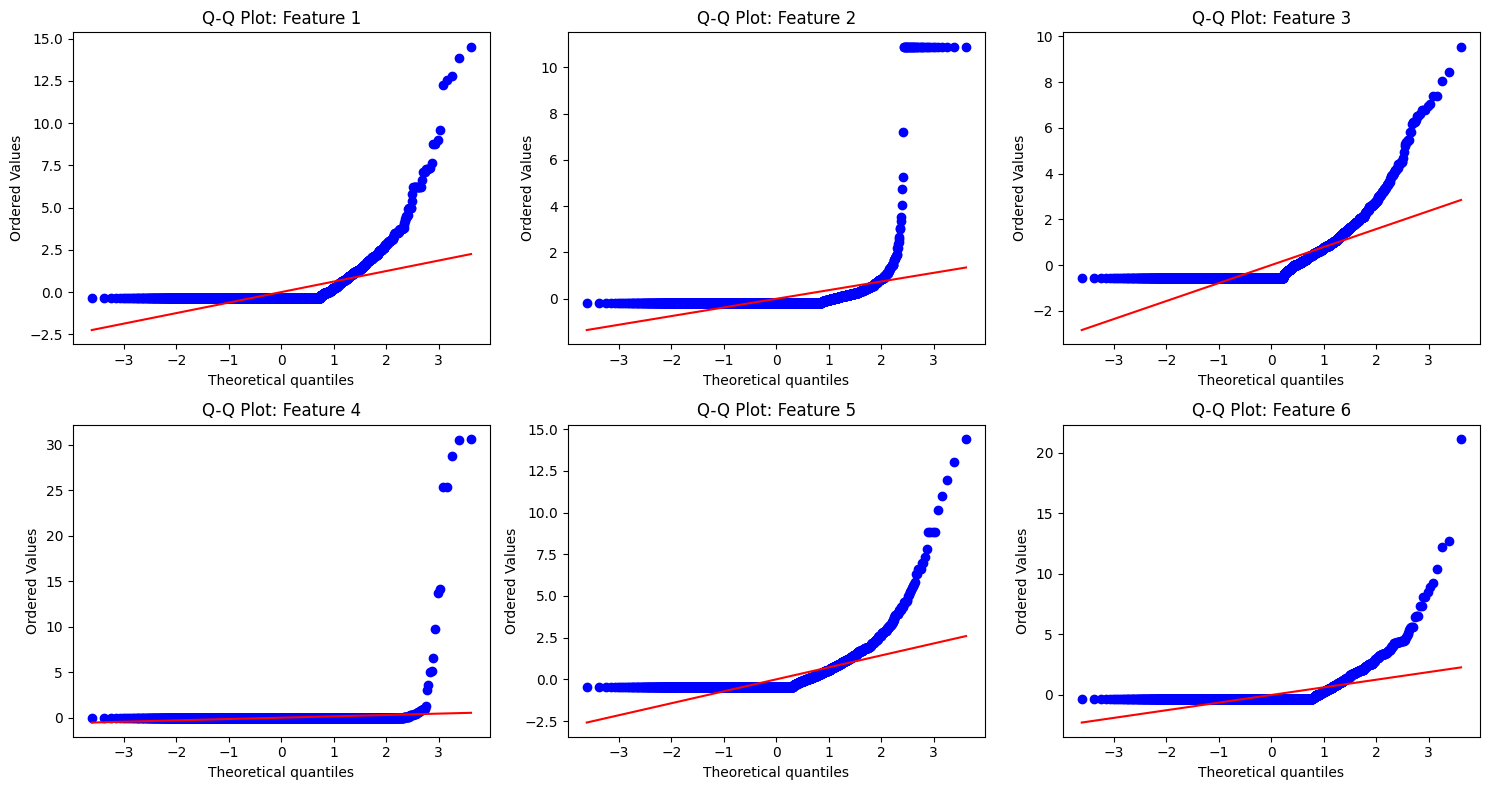

In [6]:
import matplotlib.pyplot as plt
from scipy import stats

# Check normality of first few features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i in range(6):
    # Plot histogram with normal fit
    feature_data = X_norm[:, i]
    axes[i].hist(feature_data, bins=30, density=True, alpha=0.7, edgecolor='black')

    # Fit normal distribution
    mu, std = stats.norm.fit(feature_data)
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    axes[i].plot(x, p, 'r-', linewidth=2, label='Normal fit')

    axes[i].set_title(f'Feature {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Q-Q plots for better assessment
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i in range(6):
    stats.probplot(X_norm[:, i], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot: Feature {i+1}')

plt.tight_layout()
plt.show()

"Based on the training and testing performance, does it appear the data are normally distributed?"
No, the data are clearly NOT normally distributed:

Visual evidence: Heavy concentration at zero, extreme skewness
Numerical evidence: Singular covariance matrices requiring regularization
Performance evidence: If truly Gaussian, QDA should outperform LDA with 57 features
The ~88% accuracy suggests GDA captures some useful structure but isn't optimal for this non-Gaussian data